In [ ]:
from google.colab import files
blob=files.upload()
candy=files.upload()
quality=files.upload()

Saving blob.png to blob.png


Saving candy.png to candy.png


Saving quality.png to quality.png


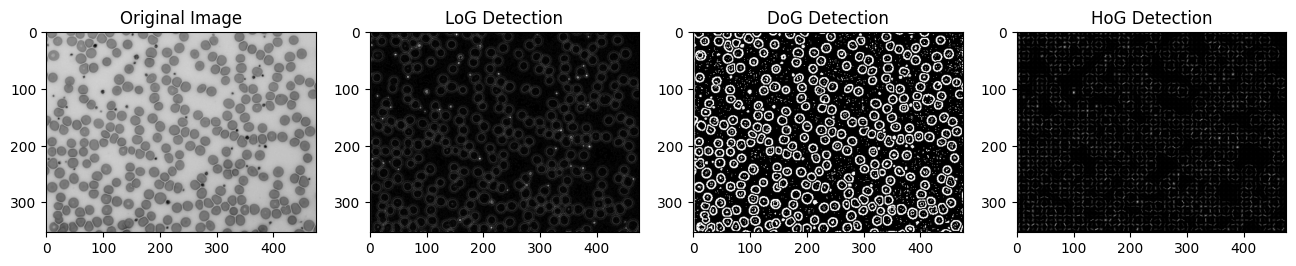

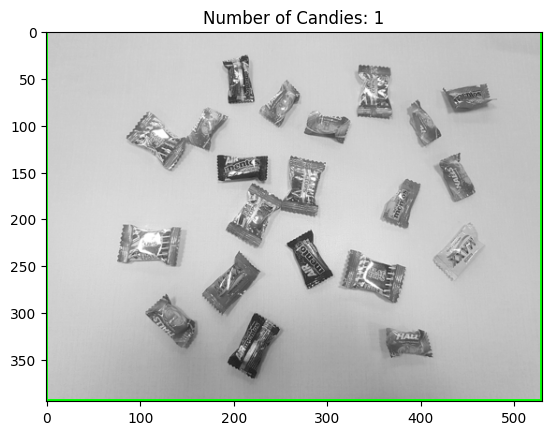

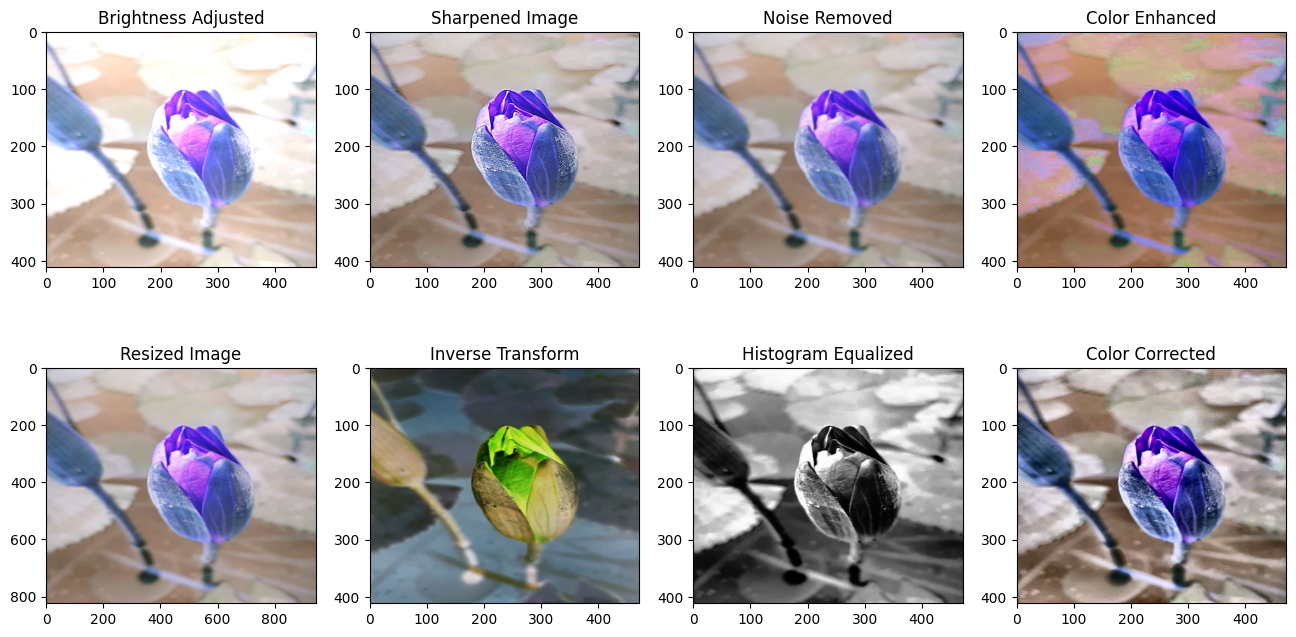

In [ ]:
# Install OpenCV if not already installed
!pip install opencv-python-headless

import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import color

# Load images (Upload first in Colab)
microscope_img = cv2.imread("/content/blob.png", cv2.IMREAD_GRAYSCALE)
candy_img = cv2.imread("/content/candy.png", cv2.IMREAD_GRAYSCALE)
quality_img = cv2.imread("/content/quality.png")

### 1️⃣ Blob Detection Techniques ###

# LoG (Laplacian of Gaussian)
def log_blob_detection(img):
    log_image = cv2.GaussianBlur(img, (5,5), 0)
    log_image = cv2.Laplacian(log_image, cv2.CV_64F)
    return np.abs(log_image)

# DoG (Difference of Gaussian)
def dog_blob_detection(img):
    gaussian1 = cv2.GaussianBlur(img, (5,5), 1)
    gaussian2 = cv2.GaussianBlur(img, (5,5), 3)
    return gaussian1 - gaussian2

# HoG (Histogram of Oriented Gradients)
def hog_blob_detection(img):
    fd, hog_image = hog(color.rgb2gray(cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)),
                        orientations=8, pixels_per_cell=(8,8),
                        cells_per_block=(2,2), visualize=True)
    return hog_image

# Apply blob detection
log_result = log_blob_detection(microscope_img)
dog_result = dog_blob_detection(microscope_img)
hog_result = hog_blob_detection(microscope_img)

# Display results
fig, ax = plt.subplots(1, 4, figsize=(16, 4))
ax[0].imshow(microscope_img, cmap='gray'); ax[0].set_title("Original Image")
ax[1].imshow(log_result, cmap='gray'); ax[1].set_title("LoG Detection")
ax[2].imshow(dog_result, cmap='gray'); ax[2].set_title("DoG Detection")
ax[3].imshow(hog_result, cmap='gray'); ax[3].set_title("HoG Detection")
plt.show()


### 2️⃣ Count the number of candies in the candy image ###
def count_candies(image):
    _, binary = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return len(contours), contours

num_candies, contours = count_candies(candy_img)

# Draw contours
candy_img_colored = cv2.cvtColor(candy_img, cv2.COLOR_GRAY2BGR)
cv2.drawContours(candy_img_colored, contours, -1, (0, 255, 0), 2)

plt.imshow(candy_img_colored)
plt.title(f"Number of Candies: {num_candies}")
plt.show()


### 3️⃣ Image Quality Enhancement Techniques ###

# Adjust Brightness & Contrast
def adjust_brightness_contrast(img, alpha=1.2, beta=30):
    return cv2.convertScaleAbs(img, alpha=alpha, beta=beta)

# Sharpening Filter
def sharpen_image(img):
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    return cv2.filter2D(img, -1, kernel)

# Noise Removal using Gaussian Blur
def remove_noise(img):
    return cv2.GaussianBlur(img, (5,5), 0)

# Color Enhancement (Convert to HSV and enhance saturation)
def enhance_color(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hsv[:, :, 1] = cv2.add(hsv[:, :, 1], 50)
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

# Resize & Scaling
def resize_image(img, scale_percent=150):
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    return cv2.resize(img, (width, height), interpolation=cv2.INTER_LINEAR)

# Inverse Transform
def inverse_transform(img):
    return cv2.bitwise_not(img)

# Histogram Equalization
def histogram_equalization(img):
    return cv2.equalizeHist(img)

# Color Correction using CLAHE
def color_correction(img):
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    l = clahe.apply(l)
    return cv2.cvtColor(cv2.merge((l,a,b)), cv2.COLOR_LAB2BGR)

# Apply transformations to satellite image
bright_s = adjust_brightness_contrast(quality_img)
sharp_s = sharpen_image(quality_img)
denoise_s = remove_noise(quality_img)
enhanced_color_s = enhance_color(quality_img)
resized_s = resize_image(quality_img, 200)
inverse_s = inverse_transform(quality_img)
equalized_s = histogram_equalization(cv2.cvtColor(quality_img, cv2.COLOR_BGR2GRAY))
color_corrected_s = color_correction(quality_img)

# Display Results
fig, ax = plt.subplots(2, 4, figsize=(16, 8))
ax[0, 0].imshow(bright_s); ax[0, 0].set_title("Brightness Adjusted")
ax[0, 1].imshow(sharp_s); ax[0, 1].set_title("Sharpened Image")
ax[0, 2].imshow(denoise_s); ax[0, 2].set_title("Noise Removed")
ax[0, 3].imshow(enhanced_color_s); ax[0, 3].set_title("Color Enhanced")

ax[1, 0].imshow(resized_s); ax[1, 0].set_title("Resized Image")
ax[1, 1].imshow(inverse_s); ax[1, 1].set_title("Inverse Transform")
ax[1, 2].imshow(equalized_s, cmap='gray'); ax[1, 2].set_title("Histogram Equalized")
ax[1, 3].imshow(color_corrected_s); ax[1, 3].set_title("Color Corrected")
plt.show()


In [ ]:
# Install PyTorch if not available
!pip install torch torchvision

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 🔹 Load MNIST Dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match ResNet input
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to 3-channel
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize
])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

# 🔹 Load Pretrained ResNet-18 Model
from torchvision import models

model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 10)  # 10 classes for MNIST
model = model.to(device)

# 🔹 Enable Mixed Precision Training (Speeds up training)
from torch.cuda.amp import autocast, GradScaler
scaler = GradScaler()

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 🔹 Train the Model
num_epochs = 3  # Faster training
for epoch in range(num_epochs):
    running_loss = 0.0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        with autocast():  # Mixed precision
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(trainloader)}")

print("Training Completed!")

# 🔹 Evaluate Model Accuracy
correct = 0
total = 0
model.eval()
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")


Using device: cuda


100%|██████████| 9.91M/9.91M [00:15<00:00, 622kB/s] 
100%|██████████| 28.9k/28.9k [00:00<00:00, 133kB/s]
100%|██████████| 1.65M/1.65M [00:06<00:00, 241kB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.77MB/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 215MB/s]
<ipython-input-2-fb9be00276ba>:38: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-2

Epoch 1, Loss: 0.07099812495500357
Epoch 2, Loss: 0.03455080945433965
Epoch 3, Loss: 0.025962707570700377
Training Completed!
Test Accuracy: 99.19%


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter, map_coordinates
from tensorflow.keras.datasets import mnist

# Load and Normalize MNIST Dataset
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images, test_images = train_images / 255.0, test_images / 255.0  # Normalize

def elastic_transform(image, alpha, sigma):
    random_state = np.random.RandomState(None)
    shape = image.shape
    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    x, y = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]), indexing='ij')
    indices = np.reshape(x + dx, (-1, 1)), np.reshape(y + dy, (-1, 1))
    return map_coordinates(image, indices, order=1).reshape(shape)

# Apply Elastic Deformations
train_images_augmented = np.array([elastic_transform(img, alpha=34, sigma=4) for img in train_images])
train_images_augmented = np.expand_dims(train_images_augmented, axis=-1).astype(np.float32)  # Ensure correct shape
test_images = np.expand_dims(test_images, axis=-1).astype(np.float32)

def create_few_shot_task(images, labels, n_classes=5, k_shot=5, q_query=15):
    selected_classes = np.random.choice(np.unique(labels), n_classes, replace=False)
    support_set, query_set, support_labels, query_labels = [], [], [], []

    for i, cls in enumerate(selected_classes):
        cls_images = images[labels == cls]
        indices = np.random.choice(len(cls_images), k_shot + q_query, replace=False)
        support_set.extend(cls_images[indices[:k_shot]])
        query_set.extend(cls_images[indices[k_shot:]])
        support_labels.extend([i] * k_shot)
        query_labels.extend([i] * q_query)

    return np.array(support_set).astype(np.float32), np.array(query_set).astype(np.float32), np.array(support_labels), np.array(query_labels)

# Define Prototypical Network
class PrototypicalNetwork(tf.keras.Model):
    def __init__(self, embedding_dim=64):
        super(PrototypicalNetwork, self).__init__()
        self.conv_net = models.Sequential([
            layers.Conv2D(64, (3, 3), activation='relu', input_shape=(28, 28, 1)),
            layers.MaxPooling2D(),
            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.MaxPooling2D(),
            layers.Flatten(),
            layers.Dense(embedding_dim, activation='relu')
        ])

    def call(self, x):
        return self.conv_net(x)

# Instantiate and Train Prototypical Network
proto_model = PrototypicalNetwork()
optimizer = tf.keras.optimizers.Adam()
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()

def train_prototypical(model, images, labels, epochs=10):
    for epoch in range(epochs):
        support_x, query_x, support_y, query_y = create_few_shot_task(images, labels)
        support_x = np.expand_dims(support_x, axis=-1).astype(np.float32)  # Ensure correct shape
        query_x = np.expand_dims(query_x, axis=-1).astype(np.float32)

        support_embeddings = model(support_x)
        query_embeddings = model(query_x)

        prototypes = []
        for cls in np.unique(support_y):
            prototypes.append(tf.reduce_mean(support_embeddings[support_y == cls], axis=0))
        prototypes = tf.stack(prototypes)

        distances = tf.norm(query_embeddings[:, None, :] - prototypes[None, :, :], axis=-1)
        predictions = tf.argmin(distances, axis=-1)
        loss = loss_fn(query_y, predictions)

        optimizer.minimize(lambda: loss, model.trainable_variables)
        print(f"Epoch {epoch+1}, Loss: {loss.numpy()}")

# Train the model
train_prototypical(proto_model, train_images_augmented, train_labels)

# Evaluate on test set
def evaluate_few_shot(model, images, labels):
    support_x, query_x, support_y, query_y = create_few_shot_task(images, labels)
    support_x = np.expand_dims(support_x, axis=-1).astype(np.float32)  # Ensure correct shape
    query_x = np.expand_dims(query_x, axis=-1).astype(np.float32)

    support_embeddings = model(support_x)
    query_embeddings = model(query_x)

    prototypes = []
    for cls in np.unique(support_y):
        prototypes.append(tf.reduce_mean(support_embeddings[support_y == cls], axis=0))
    prototypes = tf.stack(prototypes)

    distances = tf.norm(query_embeddings[:, None, :] - prototypes[None, :, :], axis=-1)
    predictions = tf.argmin(distances, axis=-1)
    accuracy = np.mean(predictions.numpy() == query_y)
    print(f"Few-Shot Learning Accuracy: {accuracy * 100:.2f}%")

evaluate_few_shot(proto_model, test_images, test_labels)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


ValueError: Argument `output` must have rank (ndim) `target.ndim - 1`. Received: target.shape=(75,), output.shape=(75,)